# Importación de bibliotecas

In [58]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree

# Preprocesamiento
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Cross validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

# Modelo red neuronal
import tensorflow as tf
from tensorflow import keras

# Carga de datos y pasos previos al entrenamiento

Importamos el dataset filtrado para comenzar a trabajar

In [59]:
ds_hotel=pd.read_csv('./hotels_train_filtrado3.csv')
ds_trabajo = ds_hotel.copy()

Aplicamos One-Hot Encoding para trabajar con las variables categóricas antes de entrenar nuestros modelos

In [60]:
# ONE HOT ENCODING ...
ds_trabajo_encoded = pd.get_dummies(ds_trabajo, columns=['hotel',
                                                 'market_segment',
                                                 'distribution_channel',
                                                 'is_repeated_guest',
                                                 'deposit_type',
                                                 'customer_type',
                                                 'agent_specified',
                                                 'more_than_zero_days_in_waiting_list',
                                                 'season',
                                                 'region',
                                                 'room_type_match'], drop_first=True)
ds_trabajo_encoded.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,total_of_special_requests,is_canceled,arrival_date,...,agent_specified_1,more_than_zero_days_in_waiting_list_1,season_Spring,season_Summer,season_Winter,region_Americas,region_Asia,region_Europe,region_Oceania,room_type_match_True
0,1.633333,1.0,2.0,0.0,0,0,115.5,1,1,1.473034e+09,...,1,0,0,1,0,1,0,0,0,1
1,0.133333,0.0,1.0,0.0,0,0,42.0,0,0,1.446250e+09,...,0,0,0,0,0,0,0,1,0,1
2,0.833333,0.0,1.0,0.0,0,0,229.0,2,0,1.476317e+09,...,1,0,0,0,0,0,0,1,0,1
3,0.866667,2.0,5.0,0.0,0,0,75.0,0,1,1.481501e+09,...,1,0,0,0,0,0,0,1,0,1
4,3.466667,2.0,5.0,0.0,0,0,75.0,1,0,1.489882e+09,...,1,0,0,0,1,0,0,1,0,1


In [61]:
ds_trabajo_encoded.columns

Index(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'adr', 'total_of_special_requests', 'is_canceled',
       'arrival_date', 'total_guests', 'hotel_Resort Hotel',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Others',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'is_repeated_guest_1',
       'deposit_type_Non Refund', 'customer_type_Transient',
       'customer_type_Transient-Party', 'agent_specified_1',
       'more_than_zero_days_in_waiting_list_1', 'season_Spring',
       'season_Summer', 'season_Winter', 'region_Americas', 'region_Asia',
       'region_Europe', 'region_Oceania', 'room_type_match_True'],
      dtype='object')

Generamos el código para mostrar las métricas y la matriz de confusión de nuestras predicciones 

In [62]:
def mostrar_metricas(y_test, y_pred):
  print(classification_report(y_test,y_pred))

  # Calcular las métricas de evaluación
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Imprimir las métricas de evaluación
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("f1 score:", f1)

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

Como Keras no tiene una métrica F1 score predefinida para  utilizar al momento de compilar redes neuronales, vamos a definir una función externa a la biblioteca que calcula el F1 score, basándonos en la implementación que se muestra en [este artículo](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d).

In [63]:
import keras.backend as K
def get_f1(y_true, y_pred): # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Modelo de Redes Neuronales

Vamos a normalizar los datos para que todas las características tengan una escala similar y no dominen unas sobre otras durante el entrenamiento de nuestras redes neuronales y para mejorar su rendimiento. Lo aplicamos luego de hacer la división train-test con proporción 70/30.

In [64]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x = ds_trabajo_encoded.drop(['is_canceled'], axis='columns')

# Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo_encoded['is_canceled'].copy()

# Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,
                                                    random_state=2)

# Armo una versión estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = pd.DataFrame(stand_scaler.fit_transform(x_train), columns=x_train.columns)
x_test_norm = pd.DataFrame(stand_scaler.transform(x_test), columns=x_test.columns)


Y establecemos una semilla para lograr que los resultados sean reproducibles.

In [65]:
# Establecer una semilla
seed_value = 2
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Modelo 1: capa de entrada, capa de salida, optimizador SGD

Observamos que nuestra red neuronal tendrá 32 neuronas de entrada y dos clases para la salida.

In [66]:
# Cantidad de clases de salida
cant_clases=len(np.unique(y_train))
# Cantidad de columnas de entrada
d_in=len(x_train_norm.columns)

print(f"Cantidad de neuronas de entrada: {d_in}")
print(f"Cantidad de clases de salida: {cant_clases}")

Cantidad de neuronas de entrada: 32
Cantidad de clases de salida: 2


Vamos a empezar entrenando una red neuronal densa simple que sólo tenga dos capas. La capa de entrada tendrá 32 neuronas (cantidad de columnas en nuestro dataset) y la de salida sólo 1 (por ser clasificación binaria). Usaremos la función sigmoide como función de activación para este modelo.

In [67]:
modelo_rn_1 = keras.Sequential([
    keras.layers.Dense(1, activation='sigmoid', input_shape=(d_in,))
])

modelo_rn_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


Compilamos el modelo. Vamos a usar el optimizador SGD con learning rate de 0.01 y la función de pérdida binary_crossentropy. La métrica a evaluar en el modelo será F1 score.

In [68]:
modelo_rn_1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

Y lo entrenamos. Vamos a definir un batch size de 32 y 12 épocas. Por lo tanto, se dividirán las 43336 muestras del dataset de train en lotes de 32 muestras, para cada una de las 12 épocas, resultando así 43336/32 = 1355 lotes por época (la implementación redondea la división hacia arriba). Dado que estamos usando SGD, que actualiza pesos después de cada lote procesado, se actualizarán los pesos 1355 veces por época, siendo así 1355*12 = 16260 actualizaciones en el entrenamiento total.

In [69]:
modelo_rn_1.fit(x_train_norm, y_train, batch_size=32, epochs=12, validation_data=(x_test_norm, y_test))

Epoch 1/12
1355/1355 [==============================] - 4s 3ms/step - loss: 0.5536 - get_f1: 0.6907 - val_loss: 0.4957 - val_get_f1: 0.7390
Epoch 2/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4854 - get_f1: 0.7405 - val_loss: 0.4834 - val_get_f1: 0.7434
Epoch 3/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4782 - get_f1: 0.7447 - val_loss: 0.4790 - val_get_f1: 0.7461
Epoch 4/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4751 - get_f1: 0.7461 - val_loss: 0.4764 - val_get_f1: 0.7497
Epoch 5/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4733 - get_f1: 0.7476 - val_loss: 0.4750 - val_get_f1: 0.7505
Epoch 6/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4720 - get_f1: 0.7466 - val_loss: 0.4740 - val_get_f1: 0.7505
Epoch 7/12
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4711 - get_f1: 0.7483 - val_loss: 0.4734 - val_get_f1: 0.7472
Epoch 8/12
1355/1355

Hacemos la predicción, convirtiendo las salidas continuas en predicciones binarias utilizando un umbral. Dado que creemos que es importante reducir los falsos negativos en el problema de predecir el estado de cancelación de reservas (es decir, queremos minimizar la clasificación incorrecta de reservas que en realidad serían canceladas, vamos a definir este umbral por debajo de 0.5, siendo así el modelo más permisivo al clasificar las reservas como canceladas. Analizamos las métricas obtenidas para distintos valores del umbral y observamos que con 0.4 mantenemos un recall y un f1 score similares. 

581/581 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      9195
           1       0.76      0.77      0.76      9378

    accuracy                           0.76     18573
   macro avg       0.76      0.76      0.76     18573
weighted avg       0.76      0.76      0.76     18573

Accuracy: 0.7579820169062618
Recall: 0.7654084026444871
Precision: 0.7577325029029874
f1 score: 0.7615511113468781


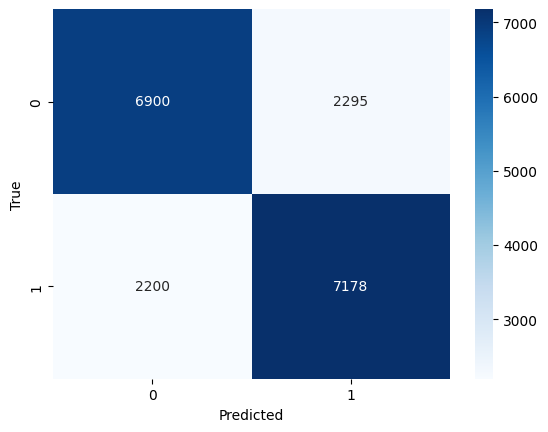

In [70]:
y_pred_norm = modelo_rn_1.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.45, 1, 0)
mostrar_metricas(y_test, y_pred)

Obtuvimos métricas decentes con este modelo de red neuronal simple. Vamos a entrenar más modelos con arquitecturas distintas para lograr mejorar estas métricas e intentar llevarlas a valores superiores a los obtenidos con modelos anteriores.

## Modelo 2: una capa oculta, optimizador Adam

Para nuestra segunda iteración, a la arquitectura de nuestra red neuronal densa le vamos a agregar una capa oculta con 20 neuronas y usará la función de activación ReLu. Para la capa de salida, usaremos la sigmoidea. 

In [71]:
modelo_rn_2 = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(d_in,)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

Esta vez vamos a compilar con el optimizador Adam y un learning rate de 0.001. Nuevamente vamos a elegir optimizar F1 score.

In [72]:
modelo_rn_2.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

Lo entrenamos con un batch size de 35 y 30 épocas.

In [73]:
modelo_rn_2.fit(x_train_norm, y_train, batch_size=35, epochs=30, validation_data=(x_test_norm, y_test))

Epoch 1/30
1239/1239 [==============================] - 4s 3ms/step - loss: 0.4733 - get_f1: 0.7392 - val_loss: 0.4442 - val_get_f1: 0.7652
Epoch 2/30
1239/1239 [==============================] - 3s 3ms/step - loss: 0.4340 - get_f1: 0.7648 - val_loss: 0.4327 - val_get_f1: 0.7674
Epoch 3/30
1239/1239 [==============================] - 4s 3ms/step - loss: 0.4223 - get_f1: 0.7742 - val_loss: 0.4227 - val_get_f1: 0.7786
Epoch 4/30
1239/1239 [==============================] - 3s 2ms/step - loss: 0.4159 - get_f1: 0.7781 - val_loss: 0.4187 - val_get_f1: 0.7850
Epoch 5/30
1239/1239 [==============================] - 3s 3ms/step - loss: 0.4099 - get_f1: 0.7843 - val_loss: 0.4160 - val_get_f1: 0.7812
Epoch 6/30
1239/1239 [==============================] - 4s 3ms/step - loss: 0.4061 - get_f1: 0.7868 - val_loss: 0.4135 - val_get_f1: 0.7815
Epoch 7/30
1239/1239 [==============================] - 4s 3ms/step - loss: 0.4021 - get_f1: 0.7894 - val_loss: 0.4106 - val_get_f1: 0.7910
Epoch 8/30
1239/1239

Observamos que se logra mejorar todas las métricas con esta nueva arquitectura. Agregar una capa oculta y modificar ligeramente otros valores resultó en que el modelo aprenda relaciones más complejas entre los datos.

581/581 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      9195
           1       0.82      0.80      0.81      9378

    accuracy                           0.81     18573
   macro avg       0.81      0.81      0.81     18573
weighted avg       0.81      0.81      0.81     18573

Accuracy: 0.8084315942497173
Recall: 0.7989976540840265
Precision: 0.8174776347370718
f1 score: 0.8081320103537533


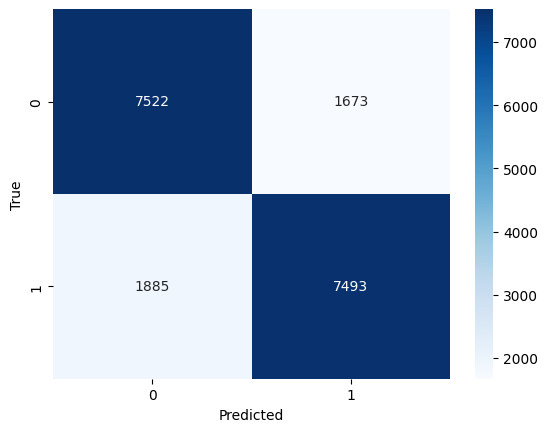

In [74]:
y_pred_norm = modelo_rn_2.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.45, 1, 0)
mostrar_metricas(y_test, y_pred)

Exportamos este primer red neuronal con métricas por encima de 80% en formato pickle

In [75]:
import pickle

with open('models/rn/rn1_model.pickle', 'wb') as archivo:
    pickle.dump(modelo_rn_2, archivo)

## Modelo 3: cuatro capas ocultas, optimizador Adam

Vamos a agregar cuatro capas ocultas, con entre 256 y 64 neuronas, cada una usará la función de activación ReLu. Para la capa de salida, usaremos la sigmoidea. 

In [95]:
modelo_rn_3 = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(d_in,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


Compilaremos con el optimizador Adam y un learning rate de 0.001.

In [99]:
modelo_rn_3.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

Vamos también a aumentar la cantidad de épocas y el batch size.

In [108]:
modelo_rn_3.fit(x_train_norm, y_train, batch_size=64, epochs=50, validation_data=(x_test_norm, y_test))

Epoch 1/50
678/678 [==============================] - 3s 5ms/step - loss: 0.3195 - get_f1: 0.8487 - val_loss: 0.5668 - val_get_f1: 0.8172
Epoch 2/50
678/678 [==============================] - 3s 4ms/step - loss: 0.3192 - get_f1: 0.8490 - val_loss: 0.5894 - val_get_f1: 0.8159
Epoch 3/50
678/678 [==============================] - 3s 5ms/step - loss: 0.3185 - get_f1: 0.8498 - val_loss: 0.5974 - val_get_f1: 0.8166
Epoch 4/50
678/678 [==============================] - 3s 4ms/step - loss: 0.3170 - get_f1: 0.8494 - val_loss: 0.6277 - val_get_f1: 0.8181
Epoch 5/50
678/678 [==============================] - 3s 4ms/step - loss: 0.3203 - get_f1: 0.8513 - val_loss: 0.5149 - val_get_f1: 0.8130
Epoch 6/50
678/678 [==============================] - 3s 4ms/step - loss: 0.3168 - get_f1: 0.8500 - val_loss: 0.5698 - val_get_f1: 0.8175
Epoch 7/50
678/678 [==============================] - 4s 6ms/step - loss: 0.3156 - get_f1: 0.8511 - val_loss: 0.4642 - val_get_f1: 0.8169
Epoch 8/50
678/678 [==============

No observamos mejorías muy significativas respecto de la arquitectura anterior.

581/581 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      9195
           1       0.80      0.84      0.82      9378

    accuracy                           0.81     18573
   macro avg       0.81      0.81      0.81     18573
weighted avg       0.81      0.81      0.81     18573

Accuracy: 0.810800624562537
Recall: 0.8417573043292813
Precision: 0.7954453849254333
f1 score: 0.8179463268055124


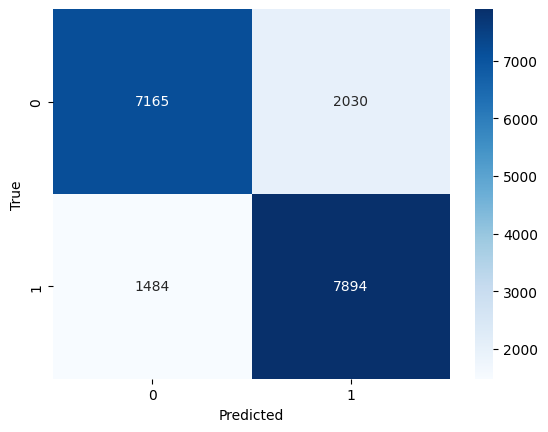

In [111]:
y_pred_norm = modelo_rn_3.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.45, 1, 0)
mostrar_metricas(y_test, y_pred)